Systems
============

In this notebook we will examine the systems in underworld. This is a continuation of the user guides and so there is a certain amount of assumed knowledge regarding swarms, mesh variables and functions.

We will start with the simplest system, the heat equation, illustrating how to setup boundary conditions. Then we will show how to create a Stokes system and solve it. Finally we demonstrate particle advection.

**This notebook is broken down into the following examples:**

1. Steady state heat equation with emphasis on boundary conditions
2. Stokes systems
3. Particle advection
4. Stokes system with particle advection

**Keywords:** underworld systems, boundary conditions, heat equation, Stokes system, advection system

**References**

1. T. J. R. Hughes. The Finite Element Method: Linear Static and Dynamic Finite Element Analysis. Prentice-Hall, Inc. 1987

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np

Simulation resolution and domain size for use in all examples below.

In [2]:
res = 64
boxLength = 1.0
boxHeight = 1.0

Steady state heat equation
-----

An example of a simple system in Underworld is the steady state heat equation given by
$$
    \nabla(k\nabla)T = h,
$$
where $k$ is the diffusivity, T is the temperature field (solved for) and $h$ is any additional heating term.

To solve this system, boundary conditions are needed and can be set up in the following way.

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

**Using specialSets to set boundary conditions**

As discussed in user guide **02_TheMesh**, the mesh consists of a list of mesh nodes each with a distinct index and spatial coordinate. 


Lets look at the special index sets - these contain the vertex numbers for along each boundary. 

In [4]:
mesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

By our convention, `I` denotes the `x` direction and `J` is the `y` direction. The vertices at the bottom of the domain are therefore contained in the set `MinJ_VertexSet`, for example.


###Setting boundary conditions

Using the above index sets we can set the boundary conditions.

In [5]:
# initialize the data for temperature
temperatureField.data[:] = 0.

Let us set the conditions on the top and bottom boundaries using the index sets.

In [6]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.0
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0.0

Let us plot the temperature field just to show the current setup.


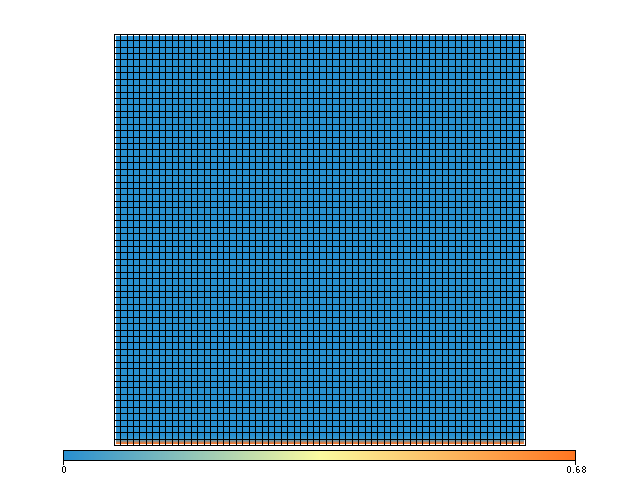

In [7]:
figtemp = glucifer.Figure()
figtemp.append( glucifer.objects.Surface( mesh, temperatureField) )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

**Flag boundaries as Dirichlet**

Using the special sets, we construct a new set of mesh indices that include the bottom and top walls.
We then use this new index set in the `DirichletCondition` class to  flag these indices on the temperature field as boundary conditions.

In [8]:
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

In [9]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

###Setup a heat equation

The heat equation requires the temperature field, the diffusivity (a function or a single value as it is here) and the boundary conditions.


In [10]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, fn_diffusivity=1.0, conditions=[tempBC,])

Next we create a solver for the system of equations.

In [11]:
heatsolver = uw.systems.Solver(heatequation)

In [12]:
heatsolver.solve()

Now draw the current temperature field.


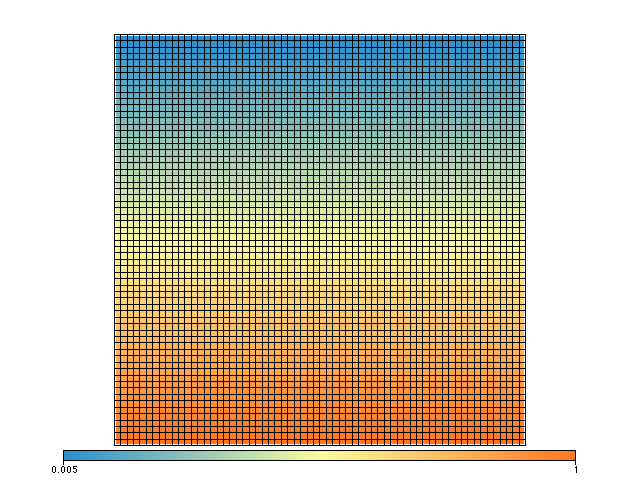

In [13]:
figtemp.show()

Stokes systems
-------

For most geodynamics problems the motion of the fluid is well described by the [Stokes equation](https://en.wikipedia.org/wiki/Stokes_flow).


Firstly we setup the mesh and some mesh variables.

In [14]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Setup some quick initial conditions.

In [15]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    temperatureField.data[index] = 1.0*(boxHeight - coord[1]) + 0.01 * pertCoeff
    temperatureField.data[index] = max(0.0, min(1.0, temperatureField.data[index]))

**Boundary conditions for velocity fields**

For two dimensional vector variables, we may flag up two Dirichlet conditions on each vertex.. for velocity it's a condition for $v_x$ and one for $v_y$. We provide a tuple of sets specifying which degrees of freedom (Set($v_x$), Set($v_y$)) should be considered Dirichlet. So the conditions below mean that the velocity components are fixed (at zero) in the horizontal direction for the side vertical walls, and fixed for the vertical components for the top and bottom walls. In other words no material can flow out of the simulation box.

As in the previous example, the temperature is held constant on the top and bottom boundaries via the tempBC object created below.

In [16]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

In [17]:
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

**Set up material parameters and functions**

Here quick functions for viscosity, density and buoyancy force are set.

In [18]:
# Set viscosity to be a constant.
viscosity = 1.
# Rayleigh number.
Ra = 1.0e4
# Construct our density function.
densityFn = Ra * temperatureField
# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

**Set up equations for the system to solve**

The Stokes system takes the pressure, viscosity and body forces (here the buoyancy) and solves for the velocity field.

In [19]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosity, 
                               fn_bodyforce   = buoyancyFn )

Create a solver for the system of equations. The system is then solved by using the ``.solve`` method on this object.

In [20]:
solver = uw.systems.Solver( stokes )

In this case the system of equations has no velocity dependence, e.g. the density function does not depend on the velocity field as is the case with swarm particles (see below). As there is no dependence on velocity then we can solve for the velocity field in a linear way. Hence the solver does not need to iterate over the velocity field.

In [21]:
solver.solve( nonLinearIterate=False )

Plot the resulting temperature and velocity fields.


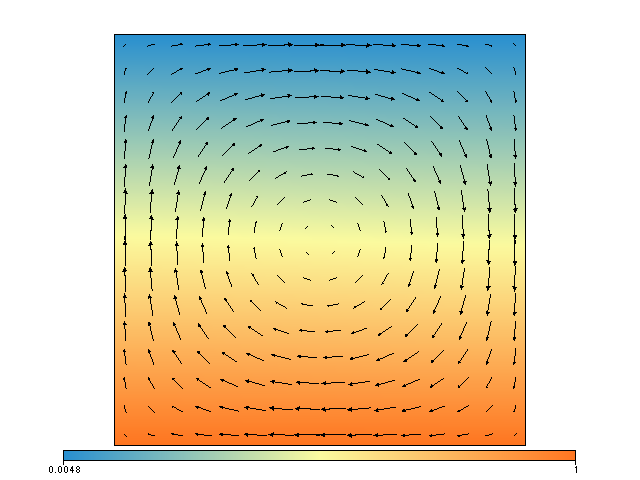

In [22]:
fig2 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2.append( glucifer.objects.VectorArrows( mesh, velocityField/(4.0), arrowHead=0.2, scaling=0.1 ) )
fig2.append( glucifer.objects.Surface( mesh, temperatureField ) )
fig2.show()

Particle advection
-----

The advection-diffusion equation for composition in the Lagrangian frame is 
$$
    \frac{ D \Gamma }{D t} = D \nabla^2 \Gamma
$$
where $\Gamma$ is composition, $D$ is diffusivity and $t$ is time. When there is no diffusion the right hand side is set to zero.


**Tracer particle moving through constant velocity field**

In this example we will use the previously calculated velocity field (stored in ``velocityField``) to advect a test particle around the simulation domain. Firstly, we create a particle swarm to add a single tracer particle to move in response to the velocity field.

In [23]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( mesh=mesh )
# Setup an array containing the position data for the tracer
particleCoordinates = np.zeros((1,2))     # 1 is for the number of particles,
                                          # 2 for the number of dimensions for the position.
# Copy position data for the sphere into the newly created array
particleCoordinates[0] = (0.5, 0.9)
# Use this array to add particles to the swarm.
swarm.add_particles_with_coordinates(particleCoordinates)
print('Initial particle coordinates = ({0:.2f}, {1:.2f})'
      .format(swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))

Initial particle coordinates = (0.50, 0.90)


Plot the initial particle position superimposed with the velocity field.


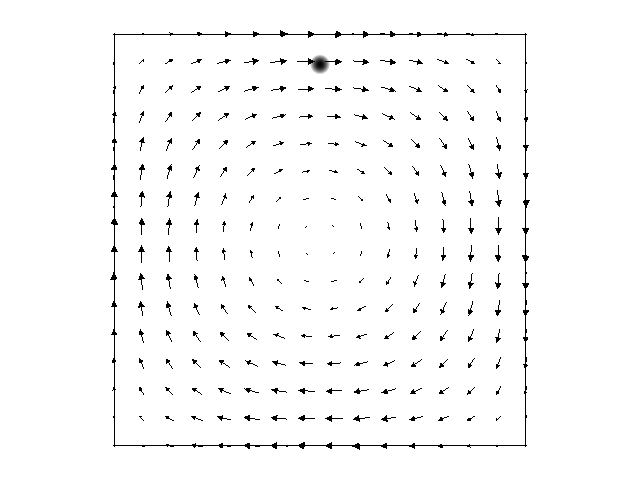

In [24]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.VectorArrows( mesh, velocityField/(6.0), arrowHead=0.4, scaling=0.1 ) )
fig2.append( glucifer.objects.Points( swarm=swarm, pointSize=20, colourBar = False ) )
fig2.show()

**Setup an advection system**

The ``SwarmAdvector`` system takes the velocity field and advects the particles in the swarm according to the velocity field.

In [25]:
advector  = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Step the tracer particle forward in time by integrating the advection system forward by a single time step. The maximum time step is determined using

$$
\Delta t = 0.5 \frac{\Delta x}{|\mathbf{u}|}
$$

in the case of independent Stokes flow and

$$
\Delta t = C \frac{ (\Delta x)^2 }{K}
$$

when the advection system also includes diffusion. Where $\Delta x$ is the minimum element width, $|\mathbf{u}|$ is the maximum velocity magnitude over the simulation domain, $C$ is the [Courant number](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition), and $K$ is the maximum value of thermal diffusivity.

The maxmimum timestep for this system is found by the following.

In [26]:
print('Maximum timestep = {0:.3e}'.format(advector.get_max_dt()))

Maximum timestep = 3.085e-03


The system is repeatedly integrated forward in time using the largest possible timestep in the following loop.

In [27]:
time = 0.
step = 0
steps_end = 10
while step < steps_end:
    # Retrieve the maximum possible timestep for the AD system.
    dt = advector.get_max_dt()
    if step == 0: # first step is initial positions (t=0)
        dt = 0.
    # Advect using this timestep size   
    advector.integrate(dt)
    step += 1
    time += dt
    print('t = {0:.3f}; x = {1:.3f}, y = {2:.3f}'
          .format(time,swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))


t = 0.000; x = 0.500, y = 0.900
t = 0.003; x = 0.507, y = 0.900
t = 0.006; x = 0.515, y = 0.900
t = 0.009; x = 0.522, y = 0.900
t = 0.012; x = 0.530, y = 0.900
t = 0.015; x = 0.537, y = 0.899
t = 0.019; x = 0.544, y = 0.899
t = 0.022; x = 0.552, y = 0.899
t = 0.025; x = 0.559, y = 0.898
t = 0.028; x = 0.566, y = 0.898


Plot final position of particle with the (constant) velocity field. As expected it has moved slightly in the direction of the velocity field at it's initial position. If the main loop is continued the particle will circulate around the simulation box.


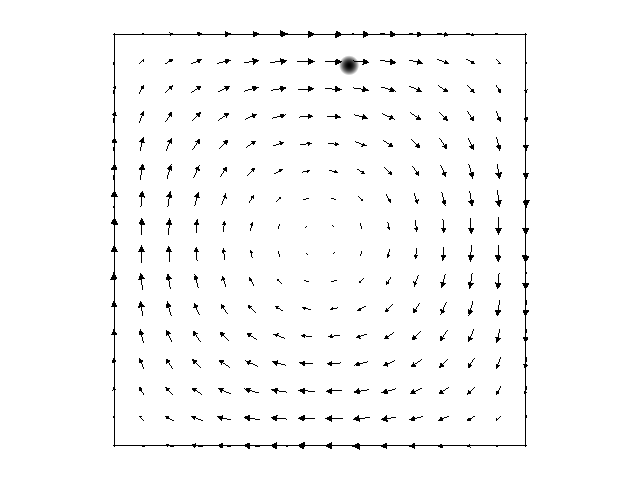

In [28]:
fig2.show()

Advection and Stokes system
-----

**Rising low density bubble**

Many geodynamical problems can be modelled by combining a Stokes system with an advection system. The advection systems moves the material forward in time according to a velocity field, which is calculated by solving the Stokes system.

Let us set up a bubble of low density fluid using particles and an advection system.

Setup new mesh and field variables

In [29]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Make a swarm over the entire region.

In [30]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )
# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="int", count=1 )
# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# Populate.
swarm.populate_using_layout( layout=swarmLayout )

Add a circle shape at the bottom with a different material index. Obtain the index for the first swarm particle that is inside the circle, this will correspond with the bottom left most particle. This makes for a quick way to track the movement of bubble as it rises. 

In [31]:
circleRadius = 0.05
circleCentre = (0.5, 2.0*circleRadius)
topBubbleID = 0
for pID in range(len(swarm.particleCoordinates.data)):
    x = swarm.particleCoordinates.data[pID][0]
    z = swarm.particleCoordinates.data[pID][1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialVariable.data[pID] = 1
        if(topBubbleID==0):
            topBubbleID = pID # will be the bottom, left most particle that is inside the circle (useful for tracking)
    else:
        materialVariable.data[pID] = 0
print('Tracer particle id = {0:6d}; Initial x = {1:.3f}, y = {2:.3f}'
      .format(topBubbleID,swarm.particleCoordinates.data[topBubbleID][0]
      ,swarm.particleCoordinates.data[topBubbleID][1]))

Tracer particle id =    102; Initial x = 0.508, y = 0.055


Plot initial conditions


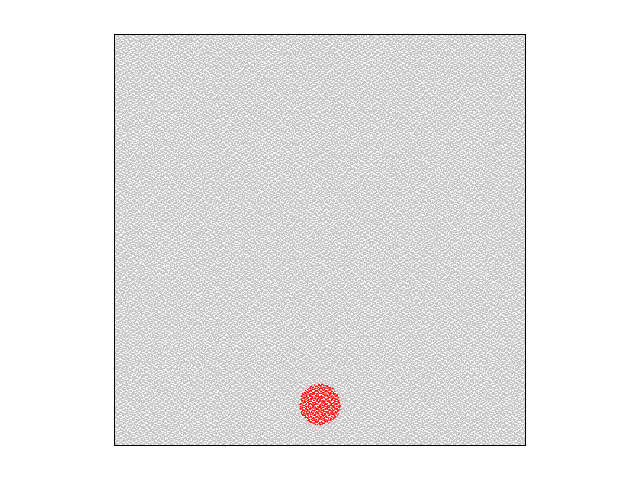

In [32]:
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialVariable, colours='grey red', 
                                colourBar = False, pointSize=2.0 ) )
fig3.show()

Set up the density, viscosity and buoyancy functions needed by the Stokes system. The density information in this example is carried by the swarm particles and is constructed using the branching function introduced in the user guide **05_Functions**.

In this example the viscosity is held constant ($\nu = 1$) across all materials.

The buoyancy function depends on the local fluid density and the vertical direction.

In [33]:
# Here we set a density of '0.' for the lightMaterial (bubble), and '1.' for the heavymaterial.
lightIndex = 1
denseIndex = 0
densityMap = { lightIndex:0., denseIndex:1. }
densityFn  = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Here we set a viscosity value of '1.' for both materials.
fn_viscosity  = fn.misc.constant(1.0)

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = -densityFn*z_hat

**Set velocity boundary conditions**

As mentioned previously, setting the boundary conditions for the velocity field in a Stokes system is more complex than for the temperature field. This is because while the temperature field has a single degree of freedom (T) at each mesh vertex, the velocity field has as many degrees of freedom as there are spatial dimensions; i.e. ${\bf v} = (v_x, v_y)$ for 2D.

In the example below, Dirichlet conditions are set on the velocity field such that $v_x$ is constant on ``allWalls`` and $v_y$ is constant only on ``jWalls``. In other words, the horizontal component of the velocity field is fixed to the initial conditions ($v_x = 0$) on all boundaries, while the vertical component is only fixed on the top and bottom boundaries ($v_y = 0$).

If we wanted $v_y = 0$ on all boundaries then the second term in the ``stokesBC`` second field should be replaced with ``allWalls``, for example.

In [34]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

# Now, using these sets, decide which degrees of freedom (on each node) should be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (allWalls, jWalls) )

**Setup a non-linear Stokes system**

We wish to illusrate a non-linear system. Now let the density function depend on the material index of the swarm particles. Because the motion of the particles depend on the velocity field this creates a **non-linear** system.

In [35]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [stokesBC,],
                               fn_viscosity   = fn_viscosity, 
                               fn_bodyforce   = buoyancyFn )
solver = uw.systems.Solver( stokes )

Setup the advection system to be dependent on the velocity field, as before.

In [36]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Main simulation time loop.

In [37]:
time = 0.
time_end = 300.
step = 0
steps_end = 20
outputEvery = 5
while time < time_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve( nonLinearIterate=True )
    # Retrieve the maximum possible timestep for the AD system.
    dt = advector.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advector.integrate(dt)
    if step%outputEvery == 0:
        print('step = {0:3d}; t = {1:7.2f}; x = {2:.3f}, y = {3:.3f}'
              .format(step,time,swarm.particleCoordinates.data[topBubbleID][0]
              ,swarm.particleCoordinates.data[topBubbleID][1]))
    step += 1
    time += dt


step =   0; t =    0.00; x = 0.508, y = 0.055
step =   5; t =   46.83; x = 0.505, y = 0.077
step =  10; t =   95.45; x = 0.503, y = 0.102
step =  15; t =  137.81; x = 0.502, y = 0.129
step =  20; t =  175.84; x = 0.502, y = 0.157
step =  25; t =  211.37; x = 0.501, y = 0.184
step =  30; t =  245.33; x = 0.501, y = 0.212
step =  35; t =  277.99; x = 0.501, y = 0.239


Plot resulting bubble position and velocity field for the entire fluid.


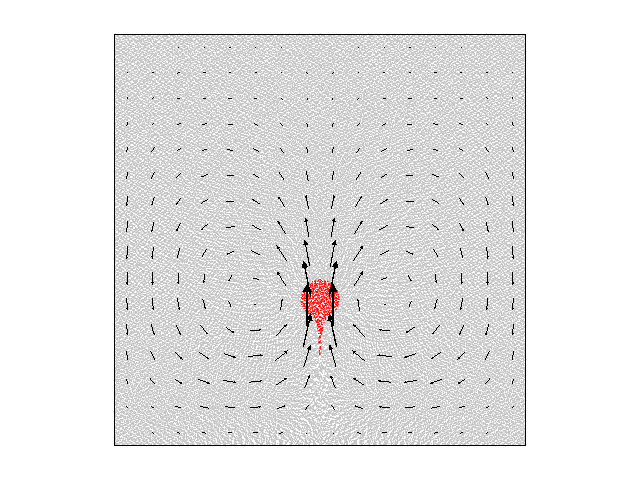

In [38]:
fig4 = glucifer.Figure()
fig4.append( glucifer.objects.VectorArrows( mesh, velocityField/(0.001), arrowHead=0.2, scaling=0.1 ) )
fig4.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialVariable, colours='grey red', 
                                colourBar = False, pointSize=2.0 ) )
fig4.show()

More information
-----

This notebook has covered advection by the velocity field only, i.e. ``uw.systems.SwarmAdvector``. The other advector system type combines advection with diffusion (heat equation) using the command ``uw.systems.AdvectionDiffusion`` which requires the velocity and temperature fields to advect the particles. A simple example of such as system is given in the example **1_02_Convection_Example**.

For more information on the interaction between advection and Stokes systems the reader is directed to the examples directory, in particular **1_05_StokesSinker** and **1_06_Rayleigh_Taylor**.